 #                     IBM APPLIED Data Science Capstone Project

#      Segmenting and Clustering Neighborhoods in Toronto


In [106]:
import numpy as np                        # library to handle data in a vectorized manner

import pandas as pd                       # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json                               # library to handle JSON files

!conda install -c conda-forge geopy --yes           # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim               # convert an address into latitude and longitude values

import requests                                    # library to handle requests
from pandas.io.json import json_normalize                 # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes          # uncomment this line if you haven't completed the Foursquare API lab
import folium                                             # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


#   WebScraping Toronto Boroughs & Pin-Codes.


Install Beautiful Soup Package & Continue....

Extract the WikiTable with 287 rows.

In [107]:
from bs4 import BeautifulSoup
import requests
import csv

source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

soup = BeautifulSoup(source, 'lxml')

table=soup.table.tbody
table_df=pd.DataFrame()

#From the wikitable copy data into a data frame
for string in table.stripped_strings:
    table_df=table_df.append([string])

#The single column data in df should be reshaped to have 3 columns
Borough_df=pd.DataFrame(table_df.to_numpy().reshape(-1,3))
Borough_df.columns = Borough_df.iloc[0]
Borough_df=Borough_df.drop(0).reset_index(drop=True)
Borough_df

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
8,M8A,Not assigned,Not assigned
9,M9A,Etobicoke,Islington Avenue


### Now that we have the required table. Let us remove 'Not assigned' [210 rows remain]  and Data Wrangling
After Wrangling, we are left with 103 unique postal codes...!

In [108]:
#Remove 'NA' Borough, if Neighbourhood="NA", make Neighbourhood value = Borough value
Borough_df=Borough_df[Borough_df['Borough']!='Not assigned'].reset_index(drop=True)

Borough_df=Borough_df.replace('Not assigned',np.NaN)
Borough_df["COL3"] = Borough_df["Neighbourhood"].fillna(Borough_df["Borough"])
Borough_df=Borough_df.drop(['Neighbourhood'],axis=1).reset_index(drop=True)
Borough_df. rename (columns={'COL3':'Neighbourhood'}, inplace=True)

#Group by Postcode & Borough with Concatenation of Neighbourhood Vales

Grouped_df=Borough_df.groupby(['Postcode','Borough'],as_index=False).agg(', '.join)
Grouped_df.head()



,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [109]:
print('\n \n The dataframe has {} boroughs \n and \n {} ROWS .'.format(
        len(Grouped_df['Borough'].unique()),
        Grouped_df.shape[0]))


 
 The dataframe has 10 boroughs 
 and 
 103 ROWS .


## Fetch data from csv file that has the geographical coordinates for Postal Codes

In [110]:
loc_df = pd.read_csv ('http://cocl.us/Geospatial_data')
loc_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [111]:
# Merge the Location Data with the Neighbourhood Data
Tor_df = pd.merge(Grouped_df, loc_df, left_on='Postcode', right_on='Postal Code', how='left')
Tor_df=Tor_df.drop(['Postal Code'],axis=1).reset_index(drop=True)
Tor_df. rename (columns={'Postcode':'Postal-Code'}, inplace=True)
Tor_df

,Postal-Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


## Create a map of Toronto Neighbourhoods using FOLIUM

# Neighbourhoods means Neighbourhood Groups that have a common Postal Code

#### Create Neighbourhood Map of Toronto

In [112]:
# Get the Latitude & Longitude Data for Toronto City
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.653963, -79.387207.


## Select only Toronto Boroughs

In [113]:
NH_df=Tor_df[Tor_df['Borough'].str.contains('Toronto')].sort_values (by = 'Neighbourhood').reset_index(drop=True)
NH_df

,Postal-Code,Borough,Neighbourhood,Latitude,Longitude
0,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568
1,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
2,M6K,West Toronto,"Brockton, Exhibition Place, Parkdale Village",43.636847,-79.428191
3,M7Y,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558
4,M5V,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo...",43.628947,-79.394420
5,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
7,M5T,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049
8,M6G,Downtown Toronto,Christie,43.669542,-79.422564
9,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160


In [114]:
# create map of Toronto with Neighbourhoods using latitude and longitude values
map_tor = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(NH_df['Latitude'], NH_df['Longitude'], NH_df['Borough'], NH_df['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor)  
    
map_tor

Enter the Fourquare credentials

In [115]:
CLIENT_ID = 'GQYZTHDW4FELZGYMP0DIQXVDFGXO5MMAVZATGRXRFKCPJV4X' # your Foursquare ID
CLIENT_SECRET = 'IWPETGS0XZIYMQBDYOZO2QRWDE0UJFHOBRA1YPTL1PK3F4SL' # your Foursquare Secret
VERSION = '20190202'
LIMIT = 100
print('Your credentails have been entered')


Your credentails have been entered


# TEST if we can obtain data from Fourquare:

### Get Restaurants data from FourSquare Toronto City [ 43.653963, -79.387207]

In [116]:
search_query = 'Restaurant'  #['Restaurant','School','Bar','Medical','Shop']
radius = 500


url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'\
.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

results = requests.get(url).json()


In [117]:
# Extract the Venues List from JSON and store in DF
venues = results['response']['venues']

# tranform venues into a dataframe
rest_df = json_normalize(venues)
rest_df=rest_df[['name','location.lat','location.lng']]
rest_df.head()

,name,location.lat,location.lng
0,Hemispheres Restaurant & Bistro,43.654884,-79.385931
1,Some Time BBQ Grill Restaurant 碳烤屋,43.655874,-79.393826
2,Hong Shing Chinese Restaurant,43.654925,-79.387089
3,Kyoto House Japanese Restaurant,43.655381,-79.385270
4,Wah Too Seafood Restaurant,43.654833,-79.387206


In [118]:

rest_df['name'].count()

40

###### There are 40 restaurants within 500m of Toronto City Center.

========================================================================================================================================================================

# CLUSTERING NEIGHBOURHOODS OF TORONTO

### PLAN:
### Toronto is among the world's most livable cities.   Check:  https://www.businessinsider.in/The-50-most-livable-cities-in-the-world-in-2018/T-7-Toronto-Canada/slideshow/65454301.cms
### 1) Cluster Neighbourhoods to find out the most LIVABLE neighbourhoods

### 2) For Every Neighbourhood , Calculate the LIVABILITY SCORE. Livalibility depends on "Lifestyle" & "Convenience"
### 3) Lifestyle Score  =  Number of Bars and Restaurants [Higher the number, higher the social life residents]
### 4) Conveninece Score  =   Number of Schools & Shops [Higher the number of these venues, the more convenient it is to live]

### 5) Finally cluster and map the Neighbourhoods based on Livability Score!!!!

#### Get the Venue Counts for all Neighbourhoods  [Actually all 39 toronto postal codes] .
#### For this repetitive process, Create a user-defined function to Get Venues & Store them in Data Frame !

In [119]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'\
.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search, radius, LIMIT)

            
        # make the GET request
        results = requests.get(url).json()
        venues = results['response']['venues']

           
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            v['name']) for v in venues])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                              'Venue Count']
    
    return(nearby_venues)

#### Use the user-defined function to get Data for all Neighbourhoods.
### Get Restaurant count for all Neighbourhoods

In [120]:
search = 'Restaurant'
Tor_venues1 = getNearbyVenues(names=NH_df['Neighbourhood'],
                                   latitudes=NH_df['Latitude'],
                                   longitudes=NH_df['Longitude']
                                  )
Tor_venues1=Tor_venues1.sort_values (by = 'Neighbourhood').reset_index(drop=True)
Tor_venues1. rename (columns={'Venue Count':'Restaurants'}, inplace=True)
Tor_Group1=Tor_venues1.groupby(['Neighbourhood'],as_index=False).count()

Tor_Group1.head()

,Neighbourhood,Restaurants
0,"Adelaide, King, Richmond",42
1,Berczy Park,13
2,"Brockton, Exhibition Place, Parkdale Village",4
3,"Cabbagetown, St. James Town",8
4,Central Bay Street,41


### Lets us now get counts for Bars,Shops & Schools

In [121]:
search = 'Bar'
Tor_venues2 = getNearbyVenues(names=NH_df['Neighbourhood'],
                                   latitudes=NH_df['Latitude'],
                                   longitudes=NH_df['Longitude']
                                  )
Tor_venues2=Tor_venues2.sort_values (by = 'Neighbourhood').reset_index(drop=True)
Tor_venues2. rename (columns={'Venue Count':'Bars'}, inplace=True)
Tor_Group2=Tor_venues2.groupby(['Neighbourhood'],as_index=False).count()

Tor_Group2.head()

,Neighbourhood,Bars
0,"Adelaide, King, Richmond",50
1,Berczy Park,45
2,"Brockton, Exhibition Place, Parkdale Village",9
3,Business Reply Mail Processing Centre 969 Eastern,3
4,"Cabbagetown, St. James Town",7


In [122]:
search = 'Shop'
Tor_venues3 = getNearbyVenues(names=NH_df['Neighbourhood'],
                                   latitudes=NH_df['Latitude'],
                                   longitudes=NH_df['Longitude']
                                  )
Tor_venues3=Tor_venues3.sort_values (by = 'Neighbourhood').reset_index(drop=True)
Tor_venues3. rename (columns={'Venue Count':'Shops'}, inplace=True)
Tor_Group3=Tor_venues3.groupby(['Neighbourhood'],as_index=False).count()

Tor_Group3.head()

,Neighbourhood,Shops
0,"Adelaide, King, Richmond",50
1,Berczy Park,24
2,"Brockton, Exhibition Place, Parkdale Village",5
3,Business Reply Mail Processing Centre 969 Eastern,2
4,"Cabbagetown, St. James Town",9


In [123]:
search = 'School'
Tor_venues4 = getNearbyVenues(names=NH_df['Neighbourhood'],
                                   latitudes=NH_df['Latitude'],
                                   longitudes=NH_df['Longitude']
                                  )
Tor_venues4=Tor_venues4.sort_values (by = 'Neighbourhood').reset_index(drop=True)
Tor_venues4. rename (columns={'Venue Count':'Schools'}, inplace=True)
Tor_Group4=Tor_venues4.groupby(['Neighbourhood'],as_index=False).count()

Tor_Group4.head()

,Neighbourhood,Schools
0,"Adelaide, King, Richmond",12
1,Berczy Park,7
2,"Brockton, Exhibition Place, Parkdale Village",3
3,"CN Tower, Bathurst Quay, Island airport, Harbo...",1
4,"Cabbagetown, St. James Town",6


### Merge Bars & Restaurants data to group based on "LIFESTYLE SCORE"

In [124]:
#Merge Totonto Neighbouhoods with Restaurants DF and Again merge with Bars DF

Tor_Lifestyle = pd.merge(pd.merge(NH_df, Tor_Group1, left_on='Neighbourhood', right_on='Neighbourhood', how='left')\
                         ,Tor_Group2, left_on='Neighbourhood', right_on='Neighbourhood', how='left')
Tor_Lifestyle=Tor_Lifestyle.fillna(0)
Tor_Lifestyle=Tor_Lifestyle.sort_values (by = 'Neighbourhood').reset_index(drop=True)
Tor_Lifestyle.head()

,Postal-Code,Borough,Neighbourhood,Latitude,Longitude,Restaurants,Bars
0,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,42.0,50.0
1,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,13.0,45.0
2,M6K,West Toronto,"Brockton, Exhibition Place, Parkdale Village",43.636847,-79.428191,4.0,9.0
3,M7Y,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,0.0,3.0
4,M5V,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo...",43.628947,-79.394420,0.0,0.0


### Merge Shops & Schools data to group based on "Convenience SCORE"

In [125]:
#Merge Totonto Neighbouhoods with Shops DF and Again merge with Schools DF

Tor_Convenience = pd.merge(pd.merge(NH_df, Tor_Group3, left_on='Neighbourhood', right_on='Neighbourhood', how='left')\
                         ,Tor_Group4, left_on='Neighbourhood', right_on='Neighbourhood', how='left')
Tor_Convenience=Tor_Convenience.fillna(0)
Tor_Convenience=Tor_Convenience.sort_values (by = 'Neighbourhood').reset_index(drop=True)
Tor_Convenience.head()

,Postal-Code,Borough,Neighbourhood,Latitude,Longitude,Shops,Schools
0,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,50.0,12.0
1,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,24.0,7.0
2,M6K,West Toronto,"Brockton, Exhibition Place, Parkdale Village",43.636847,-79.428191,5.0,3.0
3,M7Y,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,2.0,0.0
4,M5V,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo...",43.628947,-79.394420,0.0,1.0


## Merge Lifestyle & Convenience data
# The DataFrame now has "Livability Data Points" for all Neighbourhoods

In [126]:
#Merge Totonto Neighbouhoods with Restaurants DF and Again merge with Bars DF

Tor_Livable = pd.merge(Tor_Lifestyle, Tor_Convenience[['Neighbourhood','Shops','Schools']], left_on='Neighbourhood', right_on='Neighbourhood', how='left')
Tor_Livable=Tor_Livable.fillna(0)
Tor_Livable=Tor_Livable.sort_values (by = 'Neighbourhood').reset_index(drop=True)
Tor_Livable.head()

,Postal-Code,Borough,Neighbourhood,Latitude,Longitude,Restaurants,Bars,Shops,Schools
0,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,42.0,50.0,50.0,12.0
1,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,13.0,45.0,24.0,7.0
2,M6K,West Toronto,"Brockton, Exhibition Place, Parkdale Village",43.636847,-79.428191,4.0,9.0,5.0,3.0
3,M7Y,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,0.0,3.0,2.0,0.0
4,M5V,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo...",43.628947,-79.394420,0.0,0.0,0.0,1.0


## CLUSTER the neighbourhoods based on Livability Score [Lifestyle + Convenience].

## CLUSTER the neighbourhoods based on Livability Score [Lifestyle + Convenience].

In [127]:
from sklearn.preprocessing import StandardScaler

#Transform the Numerical Feature-set
cluster_livable = StandardScaler().fit_transform(Tor_Livable[['Restaurants','Bars','Shops','Schools']])
cluster_livable[0:5]


array([[ 1.78149369,  1.44811451,  2.23319659,  0.87760348],
       [-0.00632296,  1.20106085,  0.60642838, -0.00452373],
       [-0.56116261, -0.57772547, -0.58236377, -0.71022549],
       [-0.80775801, -0.87418986, -0.77006779, -1.23950182],
       [-0.80775801, -1.02242205, -0.89520381, -1.06307638]])

In [128]:
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_livable)

# check cluster labels generated for each row in the dataframe
ls_labels=kmeans.labels_
ls_labels[0:10]

array([0, 2, 1, 1, 1, 1, 3, 0, 1, 2], dtype=int32)

In [129]:
# add clustering labels

Tor_Livable["Labels"] = ls_labels
Tor_Livable=Tor_Livable.sort_values (by = 'Borough').reset_index(drop=True)
Tor_Livable

,Postal-Code,Borough,Neighbourhood,Latitude,Longitude,Restaurants,Bars,Shops,Schools,Labels
0,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,2.0,8.0,3.0,3.0,1
1,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049,4.0,11.0,6.0,4.0,1
2,M4P,Central Toronto,Davisville North,43.712751,-79.390197,4.0,2.0,0.0,5.0,1
3,M4S,Central Toronto,Davisville,43.704324,-79.388790,5.0,11.0,5.0,9.0,1
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0.0,0.0,0.0,4.0,1
5,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,0.0,0.0,0.0,3.0,1
6,M5P,Central Toronto,"Forest Hill North, Forest Hill West",43.696948,-79.411307,2.0,2.0,0.0,4.0,1
7,M5N,Central Toronto,Roselawn,43.711695,-79.416936,0.0,0.0,0.0,1.0,1
8,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,0.0,8.0,6.0,7.0,1
9,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494,9.0,19.0,13.0,10.0,2


In [130]:
# Mean values for features under each label
Tor_Livable[['Restaurants','Bars','Shops','Schools','Labels']].groupby('Labels').mean()
       

,Restaurants,Bars,Shops,Schools
Labels,,,,
0,40.571429,47.714286,41.285714,10.857143
1,2.434783,5.130435,3.043478,3.956522
2,12.000000,36.428571,18.714286,8.142857
3,43.500000,50.000000,34.000000,25.000000


In [131]:
## Mean values for features for Toronto
Tor_Livable[['Restaurants','Bars','Shops','Schools']].mean()

Restaurants    13.102564
Bars           20.692308
Shops          14.307692
Schools         7.025641
dtype: float64

In [132]:
Tor_Livable['Livability']=Tor_Livable['Labels'].replace(to_replace =[0,1,2,3], value=['Above AVG','LOW','Below AVG','HIGH'])
Tor_Livable
#df['Gender']. replace(to_replace =['male','female'], value=[0,1],inplace=True)

,Postal-Code,Borough,Neighbourhood,Latitude,Longitude,Restaurants,Bars,Shops,Schools,Labels,Livability
0,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,2.0,8.0,3.0,3.0,1,LOW
1,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049,4.0,11.0,6.0,4.0,1,LOW
2,M4P,Central Toronto,Davisville North,43.712751,-79.390197,4.0,2.0,0.0,5.0,1,LOW
3,M4S,Central Toronto,Davisville,43.704324,-79.388790,5.0,11.0,5.0,9.0,1,LOW
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0.0,0.0,0.0,4.0,1,LOW
5,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,0.0,0.0,0.0,3.0,1,LOW
6,M5P,Central Toronto,"Forest Hill North, Forest Hill West",43.696948,-79.411307,2.0,2.0,0.0,4.0,1,LOW
7,M5N,Central Toronto,Roselawn,43.711695,-79.416936,0.0,0.0,0.0,1.0,1,LOW
8,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,0.0,8.0,6.0,7.0,1,LOW
9,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494,9.0,19.0,13.0,10.0,2,Below AVG


# Some Clusters have above average values while others are below Average 

### Let us analyze the clusters visually .........

# Map the clustered Neighbourhoods on Livability Scores .!!!!


In [133]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, pos, bor, cluster in zip(Tor_Livable['Latitude'], Tor_Livable['Longitude'], Tor_Livable['Livability'], Tor_Livable['Borough'],Tor_Livable['Labels']):
    label = folium.Popup(str(bor) + '--- Cluster: ' + str(pos), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##  Downtown Toronto has the  BEST Livablility Score according to our K-Means Algorithm...........

=================================================================================================================================================

# Exploratory Data Analysis of Livability Data...........

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

EDA=Borough_df[Borough_df['Borough'].str.contains('Toronto')]

EDA1=EDA[['Postcode','Borough']].groupby('Borough').nunique()
EDA1. drop ('Borough', axis=1, inplace=True)
EDA1

,Postcode
Borough,
Central Toronto,9
Downtown Toronto,19
East Toronto,5
West Toronto,6


In [135]:
EDA2=EDA[['Neighbourhood','Borough']].groupby('Borough').nunique()
EDA2. drop ('Borough', axis=1, inplace=True)
EDA2

,Neighbourhood
Borough,
Central Toronto,17
Downtown Toronto,36
East Toronto,7
West Toronto,13


In [136]:
pd.merge(EDA1, EDA2, left_on='Borough', right_on='Borough', how='left')

,Postcode,Neighbourhood
Borough,,
Central Toronto,9,17
Downtown Toronto,19,36
East Toronto,5,7
West Toronto,6,13


<Figure size 432x288 with 0 Axes>

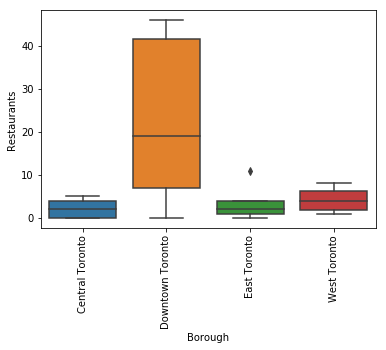

<Figure size 432x288 with 0 Axes>

In [137]:
ax = sns.boxplot(x=Tor_Livable['Borough'], y=Tor_Livable['Restaurants'], data=Tor_Livable)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.figure()

<Figure size 432x288 with 0 Axes>

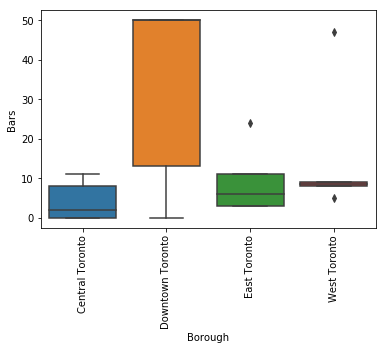

<Figure size 432x288 with 0 Axes>

In [138]:
ax = sns.boxplot(x=Tor_Livable['Borough'], y=Tor_Livable['Bars'], data=Tor_Livable)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.figure()

<Figure size 432x288 with 0 Axes>

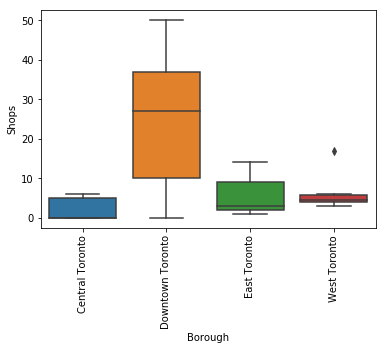

<Figure size 432x288 with 0 Axes>

In [139]:
ax = sns.boxplot(x=Tor_Livable['Borough'], y=Tor_Livable['Shops'], data=Tor_Livable)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.figure()

<Figure size 432x288 with 0 Axes>

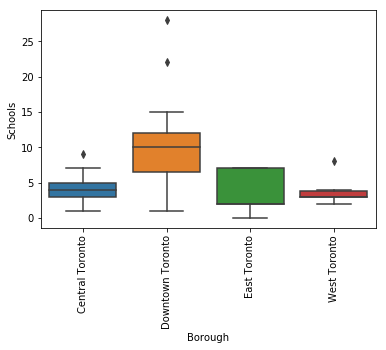

<Figure size 432x288 with 0 Axes>

In [140]:
ax = sns.boxplot(x=Tor_Livable['Borough'], y=Tor_Livable['Schools'], data=Tor_Livable)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.figure()